In [67]:

    # Model Development (ModelDevelopment.ipynb)


    #     Data preprocessing steps
    #     Incremental model training demonstrations using SGD
    #     Model evaluation (cross-validation, live metrics)
    #     Decision on model parameters and final model selection
    #     Discussions on potential production issues, e.g., model drift, retraining strategies

In [68]:
import os

project_directory = '/home/matias/repos/xtream-ai-assignment-engineer/src'

# Change the current working directory
os.chdir(project_directory)


### 1. Data Preprocessing Steps

- **Objective**: Prepare the diamonds dataset for modeling.
- **Subsections**:
  - **Data Cleaning**: Handling missing values, removing outliers, and correcting errors.
  - **Feature Engineering**: Creating new features that might help improve model performance, such as polynomial features for carat weight, or categorizing diamonds based on their dimensions.
  - **Data Transformation**: Scaling numeric data, encoding categorical variables.
  - **Data Visualization**: Visualizing distributions and relationships to understand the data better and guide further preprocessing steps.


In [69]:
import pandas as pd
import numpy as np

data = pd.read_csv('./data/diamonds/diamonds.csv')


categorical_cols = ['cut', 'color', 'clarity']
data[categorical_cols] = data[categorical_cols].astype('category')

# data = data.dropna() # no rows with missing values

### OUTLIER AND BAD DATA REMOVAL
data = data[(data['x'] != 0) & (data['y'] != 0) & (data['z'] != 0)]

data = data[(data['price'] >= 200) & (data['price'] <= 18010)]

data = data[(data['carat'] > 0) & (data['carat'] <= 3.1)]


## FEATURE TRANSFORMATIONS
data['rectangularness'] = np.abs(np.log10(data['x'] / data['y']))
data = data[data['rectangularness'] < 0.015]
data = data.drop(['x', 'y', 'z'], axis=1)

print("Data after preprocessing:")
display(data.describe())
print("\nNumber of rows after preprocessing:", len(data))

Data after preprocessing:


,carat,depth,table,price,rectangularness
count,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000
mean,0.787557,61.708726,57.441576,3862.099960,0.003428
std,0.458592,1.437076,2.261035,3852.221703,0.001606
min,0.230000,44.000000,51.600000,351.000000,0.000000
25%,0.400000,61.000000,56.000000,937.250000,0.002338
50%,0.700000,61.800000,57.000000,2383.500000,0.003048
75%,1.040000,62.500000,59.000000,5305.750000,0.004117
max,3.010000,69.800000,95.000000,18007.000000,0.014755



Number of rows after preprocessing: 4962


In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from datetime import datetime



# Assuming you have a Label column, if not present set a default label
if 'Label' not in data.columns:
    data['Label'] = 'Standard'

# Define the feature matrix X, and the target variable y
X = data.drop('price', axis=1)
y = data['price']

# Define the preprocessing pipeline
categorical_features = ['cut', 'color', 'clarity', 'Label']
numeric_features = X.columns.difference(categorical_features).tolist()

# Create the ColumnTransformer with both the numeric and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit the preprocessor and transform the feature matrix
preprocessor.fit(X)
X_preprocessed = preprocessor.transform(X)

# Apply Log to the target variable
y_preprocessed = np.log10(y)

# Save the fitted preprocessor for later use (e.g., in a production environment)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
processor_file_name = f'./model/models/preprocessor_default.joblib'
joblib.dump(preprocessor, processor_file_name)

# Now X_preprocessed is ready to be used in your model training
print(f"Transformed features shape: {X_preprocessed.shape}")


Transformed features shape: (4962, 25)


In [71]:
preprocessor.named_transformers_['cat'].categories_


[array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object),
 array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object),
 array(['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'],
       dtype=object),
 array(['Standard'], dtype=object)]

In [72]:
data.head()

,carat,cut,color,clarity,depth,table,price,rectangularness,Label
0,1.10,Ideal,H,SI2,62.0,55.0,4733,0.002620,Standard
1,1.29,Ideal,H,SI1,62.6,56.0,6424,0.001876,Standard
2,1.20,Premium,I,SI1,61.1,58.0,5510,0.005080,Standard
3,1.50,Ideal,F,SI1,60.9,56.0,8770,0.004111,Standard
4,0.90,Very Good,F,VS2,61.7,57.0,4493,0.002806,Standard


## Hyperparameter tuning

### Grid search CV

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Assuming X_preprocessed is your feature matrix after preprocessing and y is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Create a dictionary of all values we want to test for n_estimators and max_depth
params_rf = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Use GridSearch to test all values for n_estimators and max_depth
rf_gs = GridSearchCV(rf, params_rf, cv=5, verbose=3, n_jobs=-1)

# Fit model to training data
rf_gs.fit(X_train, y_train)

# Save the model that gave the best results
best_model = rf_gs.best_estimator_

# Print out the best parameters
print("Best parameters found: ", rf_gs.best_params_)

# Print out the best score
print("Best cross-validation score: ", rf_gs.best_score_)

# Evaluate the best model on the test set
test_acc = best_model.score(X_test, y_test)
print("Test set accuracy: ", test_acc)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.927 total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.935 total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.932 total time=   0.2s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.936 total time=   0.2s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=0.939 total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=0.935 total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=0.934 total time=   0.2s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=0.928 total time=   0.2s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_est

In [74]:
rf_gs.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 30}


### 3. Model Evaluation

- **Objective**: Evaluate the performance of the trained models using robust methods.
- **Subsections**:
  - **Cross-Validation**: Implementing k-fold cross-validation to estimate the performance reliably.
  - **Performance Metrics**: Discussing and calculating metrics suitable for regression tasks, such as RMSE, MAE, and R².
  - **Live Metrics**: Demonstrating how to implement and monitor metrics that can be used in a production setting.
  - **Visualizations**: Creating plots to show learning curves, prediction error, etc.


### Experiments to Assess Overfitting:

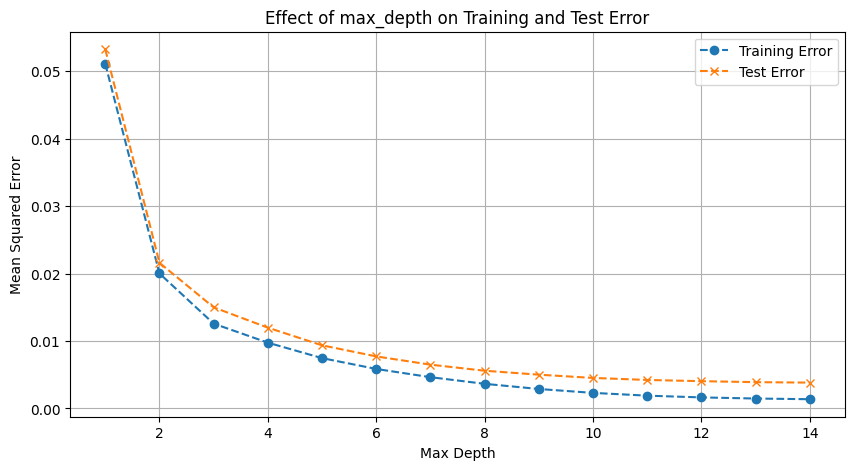

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Setup train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Range of `max_depth` values to explore
max_depth_range = range(1, 15)  # Adjust max depth to suitable range based on your data

train_errors = []
test_errors = []

for max_depth in max_depth_range:
    model = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=2, random_state=42, n_estimators=30, min_samples_split=8)
    model.fit(X_train, y_train)
    
    # Compute the training and test errors
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_predictions))
    test_errors.append(mean_squared_error(y_test, test_predictions))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(max_depth_range, train_errors, label='Training Error', linestyle='--', marker='o', lw = 1.5)
plt.plot(max_depth_range, test_errors, label='Test Error', linestyle='--', marker='x', lw = 1.5)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('Effect of max_depth on Training and Test Error')
plt.legend()
plt.grid(True)
plt.show()


Decision: Using max_depth 9, as it is the point where test error does not improve much anymore.

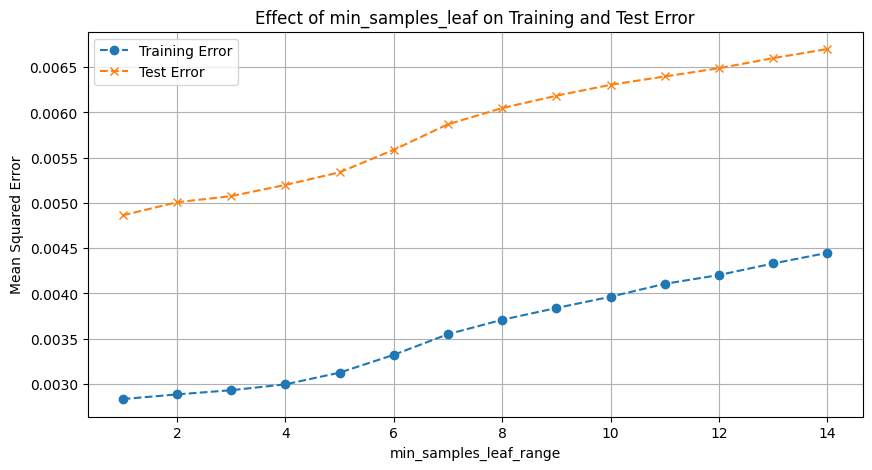

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Setup train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Range of `min_samples_leaf` values to explore
min_samples_leaf_range = range(1, 15)  # Adjust max depth to suitable range based on your data

train_errors = []
test_errors = []

for min_samples_leaf in min_samples_leaf_range:
    model = RandomForestRegressor(max_depth=9, min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=30, min_samples_split=8)
    model.fit(X_train, y_train)
    
    # Compute the training and test errors
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_predictions))
    test_errors.append(mean_squared_error(y_test, test_predictions))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_range, train_errors, label='Training Error', linestyle='--', marker='o', lw = 1.5)
plt.plot(min_samples_leaf_range, test_errors, label='Test Error', linestyle='--', marker='x', lw = 1.5)
plt.xlabel('min_samples_leaf_range')
plt.ylabel('Mean Squared Error')
plt.title('Effect of min_samples_leaf on Training and Test Error')
plt.legend()
plt.grid(True)
plt.show()


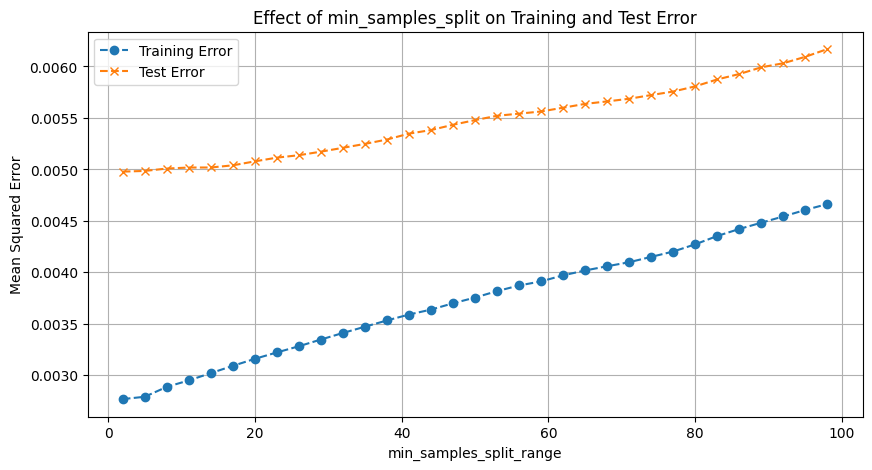

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Setup train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Range of `min_samples_split` values to explore
min_samples_split_range = np.arange(2, 100, 3)  # Adjust max depth to suitable range based on your data

train_errors = []
test_errors = []

for min_samples_split in min_samples_split_range:
    model = RandomForestRegressor(max_depth=9, min_samples_leaf=2, random_state=42, n_estimators=30, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    
    # Compute the training and test errors
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_predictions))
    test_errors.append(mean_squared_error(y_test, test_predictions))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(min_samples_split_range, train_errors, label='Training Error', linestyle='--', marker='o', lw = 1.5)
plt.plot(min_samples_split_range, test_errors, label='Test Error', linestyle='--', marker='x', lw = 1.5)
plt.xlabel('min_samples_split_range')
plt.ylabel('Mean Squared Error')
plt.title('Effect of min_samples_split on Training and Test Error')
plt.legend()
plt.grid(True)
plt.show()


Decision: Using min_samples_split 15, as it is the point where test error does not improve much anymore even if train error does.

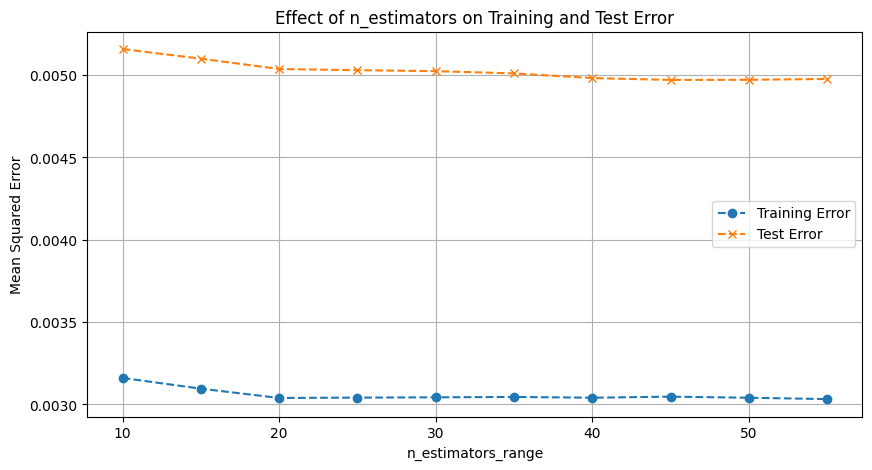

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Setup train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Range of `min_samples_split` values to explore
n_estimators_range = np.arange(10, 60, 5)  # Adjust max depth to suitable range based on your data

train_errors = []
test_errors = []

for n_estimators in n_estimators_range:
    model = RandomForestRegressor(max_depth=9, min_samples_leaf=2, random_state=42, n_estimators=n_estimators, min_samples_split=15)
    model.fit(X_train, y_train)
    
    # Compute the training and test errors
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_predictions))
    test_errors.append(mean_squared_error(y_test, test_predictions))

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, train_errors, label='Training Error', linestyle='--', marker='o', lw = 1.5)
plt.plot(n_estimators_range, test_errors, label='Test Error', linestyle='--', marker='x', lw = 1.5)
plt.xlabel('n_estimators_range')
plt.ylabel('Mean Squared Error')
plt.title('Effect of n_estimators on Training and Test Error')
plt.legend()
plt.grid(True)
plt.show()


Decision: Using 10 or 20 estimators for fast training, and 40 estimators for improved performance.


### 4. Decision on Model Parameters and Final Model Selection

- **Objective**: Finalize the model choice based on evaluation metrics and business requirements.
- **Subsections**:
  - **Parameter Tuning**: Using grid search or random search to find the optimal model parameters.
  - **Model Comparison**: Comparing different models and parameter settings based on performance metrics.
  - **Selection Rationale**: Documenting the reasons for selecting the final model including trade-offs and performance considerations.


In [79]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_estimators=40, max_depth=9, min_samples_split=15, min_samples_leaf=2)

# Fit the model to the training data
rf.fit(X_train, y_train)


## Save as default model

import joblib

# Save the model to disk
model_file_name = f'./model/models/trained_model_default.joblib'
joblib.dump(rf, model_file_name)

['./model/models/trained_model_default.joblib']

In [80]:


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_pred and y_test are defined
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



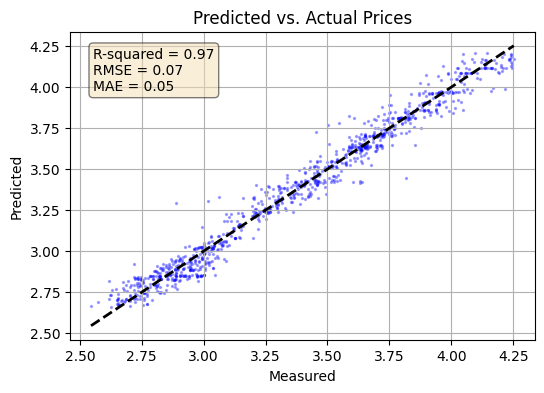

In [81]:


import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s = 2)  # Plotting the predictions vs the true values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Identity line
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Prices')
plt.grid(True)

# Annotating the plot with metrics
textstr = '\n'.join((
    f'R-squared = {r2:.2f}',
    f'RMSE = {rmse:.2f}',
    f'MAE = {mae:.2f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction', verticalalignment='top', bbox=props)

plt.show()


In [82]:

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# import joblib
# from datetime import datetime



In [83]:
# TRANSFORMATION PAIRPLOTS


# raw = data[numeric_features]

# trsf = pd.DataFrame(X_preprocessed[:, :6], columns = numeric_features)

# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming 'raw' is your DataFrame containing the original numeric features
# # and 'trsf' is your DataFrame containing the transformed numeric features

# # Combine the raw and transformed DataFrames for easier plotting
# # Add a 'Type' column to distinguish between them
# raw['Type'] = 'Raw'
# trsf['Type'] = 'Transformed'

# # Concatenate the raw and transformed data
# combined_data = pd.concat([raw, trsf])

# # Use Seaborn's pairplot to visualize the distributions and relationships
# # Note: This might be computationally intensive with large datasets
# pairplot = sns.pairplot(combined_data, hue='Type', palette='viridis', 
#                         vars=numeric_features, corner=True)

# # Enhancing the plot
# pairplot.fig.suptitle('Pairwise Comparisons of Raw and Transformed Features', y=1.02)  # Adjust title and position
# plt.show()


In [84]:
# import pandas as pd
# from data.data_preprocessing import preprocess_data
# from model import train_and_save_model, predict_price
# # Adjust the import statement 'from your_model_module' to match the actual name of your Python file containing the model functions

# # def test_model_flow():



#     print("Starting data preprocessing...")
#     # Note: Ensure your preprocess_data function is adjusted to return both X and y
#     # X, y = preprocess_data()  # X is preprocessed data, y is labels
    
#     print("Data preprocessing completed.")
    
#     print("Training and saving the model...")
#     # Train the model and save it
#     # rmse, r2 = train_and_save_model()  # Ensure train_and_save_model is implemented correctly to return metrics
#     # print(f"Model trained. RMSE: {rmse}, R^2: {r2}")
    
#     # print("Loading the trained model...")
#     # model = load_model()  # Make sure the path is correct in the load_model function
#     # print("Model loaded successfully.")
    
#     # Assuming you have the original dataset to test predictions (or you can split your dataset beforehand and save the test set)
#     original_data = pd.read_csv('datasets/diamonds/diamonds.csv')

#     # When making a prediction, ensure the data is in the correct form
#     print("Making predictions on the first ten samples of the dataset...")
#     for i in range(10):
#         # Extract the raw features for prediction
#         features_raw = original_data.iloc[[i]].drop('price', axis=1)
#         prediction = predict_price(features_raw)
#         print(f"Sample {i+1}, Prediction: {prediction[0]}")
        
#     print("Test flow completed.")

# if __name__ == "__main__":
#     test_model_flow()


In [85]:
# print(preprocessor)

# # Check if it's a ColumnTransformer
# if hasattr(preprocessor, 'transformers_'):
#     print("ColumnTransformer details:")
#     for transformer_name, transformer, columns in preprocessor.transformers_:
#         print(f"Transformer: {transformer_name}")
#         print(f" - Transformer object: {transformer}")
#         print(f" - Columns: {columns}")
#         if hasattr(transformer, 'categories_'):
#             print(f" - Fitted categories: {transformer.categories_}")



# # Specific check for OneHotEncoder in a pipeline within a ColumnTransformer
# for transformer_name, transformer, columns in preprocessor.transformers_:
#     if hasattr(transformer, 'named_steps'):  # It's a pipeline
#         for step_name, step in transformer.named_steps.items():
#             if isinstance(step, OneHotEncoder):
#                 print(f"Categories for {columns} in {step_name}: {step.categories_}")



In [86]:

# import sys
# sys.path.append('/home/matias/repos/xtream-ai-assignment-engineer/src')

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# import joblib
# from datetime import datetime


# def initialize_default_preprocessor():
#     data = pd.read_csv('./../src/data/diamonds/diamonds.csv')
#     if 'Label' not in data.columns:
#         data['Label'] = 'Standard'
    
#     y = data['price']
#     X = data.drop(columns=['price'])
    
#     numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
#     categorical_features = ['cut', 'color', 'clarity', 'Label']

#     numeric_transformer = Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler())
#     ])

#     categorical_transformer = Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ])

#     preprocessor = ColumnTransformer([
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])
    
#     preprocessor.fit(X)
#     joblib.dump(preprocessor, './../src/model/models/default_preprocessor.joblib')
#     return preprocessor

In [88]:

# Load the best model to ensure what is saved is what is evaluated
loaded_model = joblib.load('./model/models/trained_model_default.joblib')
model = loaded_model

In [90]:
# cross_val_score

from sklearn.model_selection import cross_val_score

In [91]:

# Cross-validation to estimate performance on the train set
cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print("CV RMSE: Mean =", mean_cv_rmse, "| Std Deviation =", std_cv_rmse)

# Predict on the testing set using the loaded model
y_pred = model.predict(X_test)

# Calculate metrics on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Root Mean Squared Error: {rmse}")
print(f"Test Set R^2 Score: {r2}")


CV RMSE: Mean = 0.06568749692244595 | Std Deviation = 0.0018895676470438688
Test Set Root Mean Squared Error: 0.07058689483008732
Test Set R^2 Score: 0.9744985055103141


In [92]:
cv_rmse_scores

array([0.06860412, 0.06608885, 0.06426263, 0.06379439])

In [93]:
100/4990

0.02004008016032064

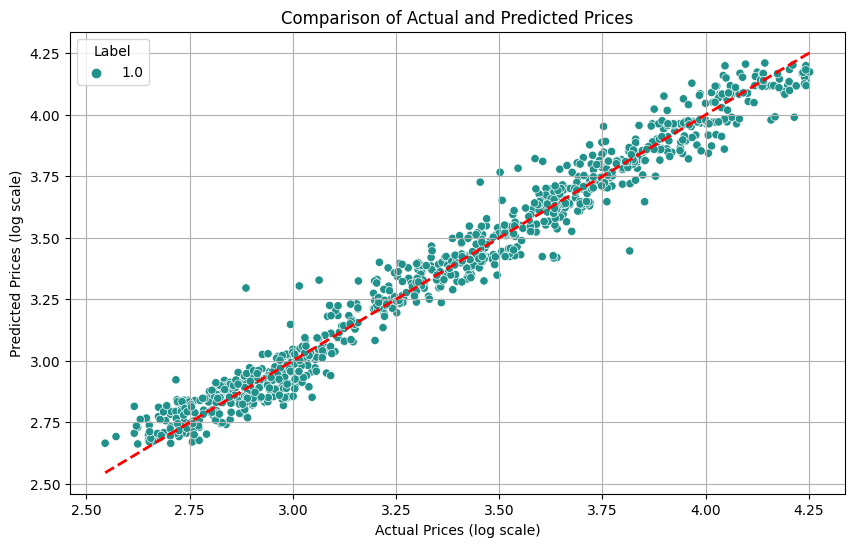

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are already defined from your previous model evaluation
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred)

# Create a DataFrame to make plotting easier
test_predictions = pd.DataFrame({
    'Actual Prices': y_test,
    'Predicted Prices': y_pred,
    'Label': X_test[:, -1]  # Assuming the label data is kept in X_test
})

sns.scatterplot(x='Actual Prices', y='Predicted Prices', hue='Label', data=test_predictions, palette='viridis', style='Label')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Actual Prices (log scale)')
plt.ylabel('Predicted Prices (log scale)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Add a reference line
plt.grid(True)
plt.show()


In [95]:
# Assuming you already have y_test and y_pred from the previous steps
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})

# Reset index if y_test is a pandas Series with an index that doesn't start from 0
comparison_df.reset_index(drop=True, inplace=True)

# Sample 10 random rows from the DataFrame for a quick assessment
sample_comparison_df = comparison_df.sample(n=10, random_state=42)  # Use a fixed random state for reproducibility

print("Sample of Test Set Predictions:")
print(sample_comparison_df)


Sample of Test Set Predictions:
     Actual Price  Predicted Price
918      2.678518         2.687991
525      3.609061         3.566307
567      4.060282         4.086355
656      3.908324         3.956100
915      3.616581         3.637518
429      3.760272         3.780234
855      3.875582         4.023112
711      3.409087         3.480889
174      3.540079         3.554937
604      3.017451         2.927460
